In [1]:
import numpy as np
import cProfile
import itertools
import heapq

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Solving the 8-puzzle problem with the A* algorithm: step by step

The numerical 8-puzzle consists of a 3x3 board, where from an initial state, you want to reach an objective state. In this notebook, our objective will be to form a sequence from 1 to 8, moving the pieces to the blank space, as shown in the figure below.


<img src="images/8puzzle.png">


This problem belongs to the family of sliding block puzzles, which are **often used as test problems for new search algorithms in Artificial Intelligence.**

There are several search algorithms, such as breadth-first search (BrFS - Breadth-first search), which we can also call “blind search”, as it does not have any additional information about the states. They just generate successors and distinguish whether the generated successor is the objective state or not.

Search algorithms can tell us whether a non-objective state is more promising than another are called informed search (heuristic), a category in which the A* algorithm (A star) falls into.

In this notebook, we will explore the 8-puzzle problem using the A* algorithm, to find the best path to reach our objective state.

# A * (A Star)

A* is an informed search algorithm or heuristic, which means it uses an estimate of the cost to reach the current node's goal to make intelligent decisions about which nodes to explore next.

It is the most widely known solution of the best choice search. Basically, this algorithm evaluates which nodes will be explored, based on the smallest value of the evaluation function f(n), which in turn is a combination of g(n), the cost to reach the state, and h(n), the cost to get from node to goal.

So, we have: f(n) = g(n) + h(n)

h(n) is the function defined by the problem heuristic. The heuristic uses knowledge of a specific problem in addition to the definition of the problem itself. Thinking about our puzzle problem, we can think of two heuristics:

1. The number of pieces in the wrong position
2. The number of movements required to reach the correct position

Taking the initial state below, we can say that h(n) using heuristic 1 would be equal to 8, and for heuristic 2 equal to 16.


<img src="images/estado_inicial.png">

As we can see, heuristic 1 is extremely optimistic, as we are disregarding the allowed actions of the problem itself. Using this premise, we could say that to reach the objective state, it would be enough to simply remove each piece from the wrong position and place it in the correct position in just 1 movement.

Heuristic 2, on the other hand, is more realistic, but maintains the admissibility criterion, a condition for optimality (the strategy finds the optimal solution, when it exists) of algorithm A*. An acceptable heuristic will never overestimate the true cost of a solution**. Later, we will compare the results using the two heuristics presented here and the impact on the algorithm's performance.

## Basic operation of A*

Let's move on to how the algorithm works. As shown in the image below, we define our initial state (on the left), and objective state (on the right)!

<img src="images/8puzzle.png">

In general, we need to manage two data structures, which we will call OPEN and CLOSE.

OPEN contains all nodes that have been generated but not explored, i.e., the future states of the current node have not yet been created. This is a list of "pending tasks", being managed by a priority queue based on f(n). CLOSE contains the nodes that have been generated and expanded.

Thus, we have 5 basic steps of the algorithm:

1. We add the initial state node to the OPEN list

2. We remove from OPEN the current node with the smallest f(n), in the first step, it will always be the initial state.

3. If the state of the current selected node is equal to the goal state, we found the solution, we recover the path! It is important to say that the verification of the initial state with the goal state is done at the time of expansion, and not at the time a node is generated. This way, we guarantee to find the shortest path, and not return the first path found.

4. All possible states are generated from the current node, and the f(n) of each successor is calculated.

5. For each successor of the current node, we add it to the OPEN list if the state is not already in the CLOSE list.

This process is exemplified in the image below. We have the initial state, and from there, we have 4 more possible states. Initial state is added to the CLOSE LIST, as it has already been expanded, and its successors to the OPEN LIST in order of f(n). This way, the next node to be expanded will be the one with the lowest f(n).

<img src="images/exemplo_exec.png">

# Implementation

The first step is to create our Node class, which will be responsible for storing information about our state, and its parent so that we can recover the path when the goal state is found.

In [2]:
class Node:
    def __init__(self, state,  parent=None, gn=0, fn=0):
        self.state = state
        self.parent = parent
        self.gn = gn
        self.fn = fn

The second step is managing our OPEN list. In this implementation, we create a list of "tasks", that is, nodes in our OPEN list that are being managed by a priority queue (here we use python's heapq library). A good implementation of this priority queue is essential for more efficient execution!

We add a node to the OPEN list only if it does not exist, or, if it exists, and the current f(n) is smaller, we replace it. This way, we guarantee that we will not expand states at a greater cost than necessary.

In [3]:
class PriorityQueue():

    REMOVED = '<removed-task>'     

    def __init__(self):
        self.pq = []
        self.entry_finder = {} 
        self.counter = itertools.count()  
        #self.counter_opened = itertools.count()
        #self.count_opened = 0
        self.count = 0

    def add_task(self, task, node, priority=0):
        'Add a new task or update the priority of an existing task'
        if(task in self.entry_finder and priority >= self.entry_finder[task][0]):
            return
        if (task in self.entry_finder and priority < self.entry_finder[task][0]):
            self.remove_task(task)
            self.count = self.count - 1
        count = next(self.counter)
        entry = [priority, count, task, node]
        self.entry_finder[task] = entry
        heapq.heappush(self.pq, entry)
        #self.count_opened = next(self.counter_opened)
        self.count = self.count +1

    def remove_task(self,task):
        'Mark an existing task as REMOVED.  Raise KeyError if not found.'
        entry = self.entry_finder.pop(task)
        entry[-1] = self.REMOVED

    def pop_task(self):
        'Remove and return the lowest priority task. Raise KeyError if empty.'
        while self.pq:
            priority, count, task, node = heapq.heappop(self.pq)
            if node is not self.REMOVED:
                del self.entry_finder[task]
                return True, task, node
            
        return False, None, None 

Another important part before we move on to actually implementing A*, is defining the calculation functions of our heuristics (getCustoHeuristica1 and getCustoHeuristica2) as well as the definition of possible actions (get_sucessors), that is, how the expansion is done.

In [4]:
def getPosition(state, element):
    # Iterate through rows and columns to find the indices
    for row_index, row in enumerate(state.state):
        for col_index, value in enumerate(row):
            if value == element:
                return (row_index, col_index)

def getCustoHeuristica2(state, obj_state):

    #Sum of the Manhattan distances of each element to its final position
    elements = [1,2,3,4,5,6,7,8]
    custo = 0

    for element in elements:
         
    
        point1 = getPosition(obj_state, element)
        point2 = getPosition(state, element)

        x1, y1 = point1
        x2, y2 = point2

        custo+= abs(x2 - x1) + abs(y2 - y1)


    return custo

def getCustoHeuristica1(state, obj_state):
    state_node = np.array(state.state)
    state_goal = np.array(obj_state.state)

    differences = 0
    
    # Count differences using element-wise comparison
    differences = np.sum(state_node != state_goal)

    return differences - 1

def get_sucessors(node):
    x, y = tuple(getPosition(node, 0))
    sucessors = []

    # Add adjacent nodes (up, down, left, right)
    for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:

        new_x, new_y = x + dx, y + dy
        if(((new_x > 2 or new_y > 2) or (new_x < 0 or new_y < 0))):
            continue

        updated_state = [[element for element in row] for row in node.state] 
        temp_value = node.state[new_x][new_y]
        updated_state[new_x][new_y] = node.state[x][y]
        updated_state[x][y] = temp_value

        new_node = Node(updated_state, parent=node, gn=node.gn + 1)
        sucessors.append(new_node)

    return sucessors

## A* Implementation

In [5]:
def astar(start, goal, heuristic):

    print("Executing A* algorithm with heuristic ", heuristic)

    
    open_list = PriorityQueue()
    closed_list = set()
    number_visited_states = 0
    states_visited = []
    status=True
    total_cost = 0
    goal_state = tuple([element for sublist in goal.state for element in sublist])

    # Put node_start in the OPEN list with
    state_inicial = tuple([element for sublist in start.state for element in sublist])
    if(heuristic == 1):
        fn = start.gn + getCustoHeuristica1(start, goal)
        start.fn = fn
        open_list.add_task(state_inicial, start, fn)
    
    elif(heuristic == 2):
        fn = start.gn + getCustoHeuristica2(start, goal)
        start.fn = fn
        open_list.add_task(state_inicial, start, fn)
    
    
    while status:
        #Take from the open list the node node_current with the lowest cost
        status, task, current_node = open_list.pop_task()


        if(status == False):
            print("There is no solution")
    
            return [], open_list, closed_list, 0, 0

        if (task == goal_state):
                # Goal reached, construct and return the path
                path = []
                fns_teste = []
                prof = current_node.gn
                while current_node:
                    path.append(current_node.state)
                    fns_teste.append(current_node.fn)
                    total_cost = total_cost + current_node.fn
                    current_node = current_node.parent
                return path[::-1],  open_list, closed_list, prof, total_cost

        closed_list.add(task)

        
        # Generate each state node_successor that come after node_current
        states_visited.append(task)
        for sucessor in get_sucessors(current_node):
            #if node in closed list, it has been expanded already
            if tuple([element for sublist in sucessor.state for element in sublist]) in closed_list:
                continue

            gn = current_node.gn + 1
            
            if(heuristic == 1):
                fn = gn + getCustoHeuristica1(sucessor, goal)
       
            elif(heuristic == 2):
                fn = gn + getCustoHeuristica2(sucessor, goal)
    

            sucessor.fn = fn
            
            state_atual = tuple([element for sublist in sucessor.state for element in sublist])
            open_list.add_task(state_atual, sucessor, fn)

    return [], open_list, closed_list, 0, number_visited_states

It is possible to determine whether or not the puzzle has a solution from the initial state, counting the number of inversions.

In [6]:
def count_inversions(state):
    inversion_count = 0
    flatten_state = [value for row in state for value in row if value != 0]

    for i in range(len(flatten_state)):
        for j in range(i + 1, len(flatten_state)):
            if flatten_state[i] > flatten_state[j]:
                inversion_count += 1

    return inversion_count

def is_solvable(initial_state, goal_state):
    initial_inversions = count_inversions(initial_state)
    goal_inversions = count_inversions(goal_state)

    if (initial_inversions % 2 == 0 and goal_inversions % 2 == 0) or \
       (initial_inversions % 2 != 0 and goal_inversions % 2 != 0):
        return True
    else:
        return False 

# Pipeline execution

In [7]:
def main():

    
    initial_state_1 = [
        [7, 5, 3],
        [2, 0, 4],
        [6, 8, 1]
    ]

    not_solvable_1 = [
        [8, 4, 7],
        [6, 5, 0],
        [3, 2, 1]
    ]

    not_solvable_2 = [
        [8, 4, 7],
        [6, 5, 3],
        [0, 2, 1]
    ]

    not_solvable_3 = [
        [7, 5, 3],
        [2, 1, 4],
        [6, 8, 0]
    ]

    goal_state = [
        [0, 1, 2], 
        [3, 4, 5],
        [6, 7, 8]
    ]

    start = initial_state_1

    if is_solvable(start, goal_state):
        print("8 Puzzle in this initial state has a solution")
    else:
        print("8 Puzzle in this initial state has no solution")

    print("\n")
    start = Node(start, gn=0, fn=0)
    obj_state = Node(goal_state, gn=0, fn=0)

    path, open_list, closed_list, prof, total_cost = astar(start, obj_state, heuristic=2)

    print("\n")
    print('Expected total cost: ', total_cost)
    print("Number of expanded states: ", len(closed_list))
    print("Number of states generated: ", open_list.count)
    print('Number of states on the border: ', len(open_list.entry_finder))


    if(path):
        print("Actual cost of the solution: ", prof)
        print("PATH")
        for state in path:
            for row in state:
                print(row)
            print(" ")
    print("\n")
    print("-----------------------------------------------------------------------------------------------------------")
    print("\n")
    print("RUNTIME DETAILS \n\n")

if __name__ == '__main__':
    cProfile.run('main()')

8 Puzzle in this initial state has a solution


Executing A* algorithm with heuristic  2


Expected total cost:  502
Number of expanded states:  2492
Number of states generated:  3812
Number of states on the border:  1319
Actual cost of the solution:  24
PATH
[7, 5, 3]
[2, 0, 4]
[6, 8, 1]
 
[7, 0, 3]
[2, 5, 4]
[6, 8, 1]
 
[7, 3, 0]
[2, 5, 4]
[6, 8, 1]
 
[7, 3, 4]
[2, 5, 0]
[6, 8, 1]
 
[7, 3, 4]
[2, 0, 5]
[6, 8, 1]
 
[7, 0, 4]
[2, 3, 5]
[6, 8, 1]
 
[0, 7, 4]
[2, 3, 5]
[6, 8, 1]
 
[2, 7, 4]
[0, 3, 5]
[6, 8, 1]
 
[2, 7, 4]
[3, 0, 5]
[6, 8, 1]
 
[2, 0, 4]
[3, 7, 5]
[6, 8, 1]
 
[2, 4, 0]
[3, 7, 5]
[6, 8, 1]
 
[2, 4, 5]
[3, 7, 0]
[6, 8, 1]
 
[2, 4, 5]
[3, 7, 1]
[6, 8, 0]
 
[2, 4, 5]
[3, 7, 1]
[6, 0, 8]
 
[2, 4, 5]
[3, 0, 1]
[6, 7, 8]
 
[2, 0, 5]
[3, 4, 1]
[6, 7, 8]
 
[0, 2, 5]
[3, 4, 1]
[6, 7, 8]
 
[3, 2, 5]
[0, 4, 1]
[6, 7, 8]
 
[3, 2, 5]
[4, 0, 1]
[6, 7, 8]
 
[3, 2, 5]
[4, 1, 0]
[6, 7, 8]
 
[3, 2, 0]
[4, 1, 5]
[6, 7, 8]
 
[3, 0, 2]
[4, 1, 5]
[6, 7, 8]
 
[3, 1, 2]
[4, 0, 5]
[6, 7, 8]
 
[3, 

# Comparing Heuristics

In [8]:
initial_state_1 = [
    [7, 5, 3],
    [2, 0, 4],
    [6, 8, 1]
]

initial_state_2 = [
    [7, 5, 3],
    [1, 2, 4],
    [6, 8, 0]
]

initial_state_3 = [
    [7, 2, 4],
    [1, 5, 3],
    [6, 8, 0]
]

initial_state_4 = [
    [7, 2, 4],
    [8, 1, 3],
    [6, 5, 0]
]

goal_state = [
    [0, 1, 2], 
    [3, 4, 5],
    [6, 7, 8]
]


solvable_states = [initial_state_1, initial_state_2, initial_state_3, initial_state_4]


In [9]:
dict_comp = {
    'initial_state': [],
    'heuristic': [],
    'expanded_nodes': [],
    'created_nodes': [],
    'nodes_border': [],
    'prof_soluc': []
}

goal_state = [
    [0, 1, 2], 
    [3, 4, 5],
    [6, 7, 8]
]

heuristics = [1,2]
for heuristic in heuristics:
    for initial_state in solvable_states:
        start = initial_state

        start = Node(start, gn=0)
        obj_state = Node(goal_state, gn=0)

        path, open_list, closed_list, prof, total_cost = astar(start, obj_state, heuristic)

        print("\n")
        dict_comp['initial_state'].append(tuple([element for sublist in start.state for element in sublist]))
        dict_comp['heuristic'].append(heuristic)
        dict_comp['expanded_nodes'].append(len(closed_list))
        dict_comp['created_nodes'].append(open_list.count)
        dict_comp['nodes_border'].append(len(open_list.entry_finder))
        dict_comp['prof_soluc'].append(prof)

result = pd.DataFrame(dict_comp)
result

Executing A* algorithm with heuristic  1


Executing A* algorithm with heuristic  1


Executing A* algorithm with heuristic  1


Executing A* algorithm with heuristic  1


Executing A* algorithm with heuristic  2


Executing A* algorithm with heuristic  2


Executing A* algorithm with heuristic  2


Executing A* algorithm with heuristic  2




,initial_state,heuristic,expanded_nodes,created_nodes,nodes_border,prof_soluc
0,"(7, 5, 3, 2, 0, 4, 6, 8, 1)",1,22944,33229,10284,24
1,"(7, 5, 3, 1, 2, 4, 6, 8, 0)",1,3507,5524,2016,20
2,"(7, 2, 4, 1, 5, 3, 6, 8, 0)",1,3640,5768,2127,20
3,"(7, 2, 4, 8, 1, 3, 6, 5, 0)",1,8483,12926,4442,22
4,"(7, 5, 3, 2, 0, 4, 6, 8, 1)",2,2492,3812,1319,24
5,"(7, 5, 3, 1, 2, 4, 6, 8, 0)",2,455,703,247,20
6,"(7, 2, 4, 1, 5, 3, 6, 8, 0)",2,561,905,343,20
7,"(7, 2, 4, 8, 1, 3, 6, 5, 0)",2,838,1312,473,22


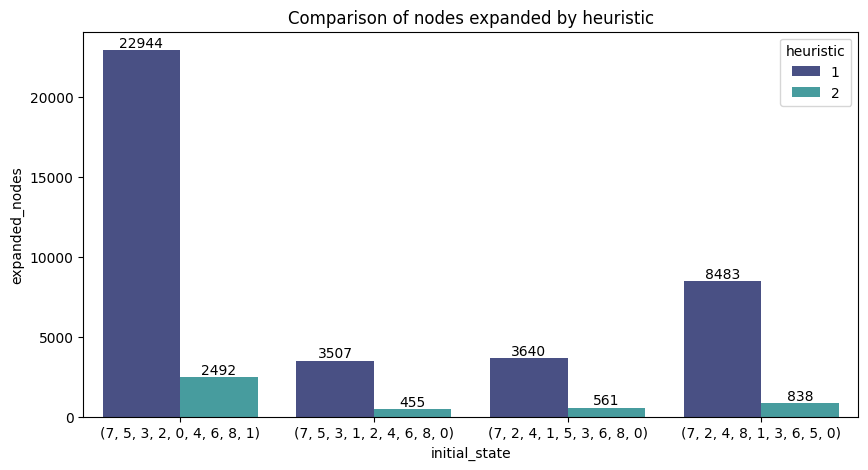

In [10]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='initial_state', y='expanded_nodes',
                 hue='heuristic', data=result,
                 errwidth=0,
                 palette="mako")
 
ax.set_title('Comparison of nodes expanded by heuristic')

for i in ax.containers:
    ax.bar_label(i,)

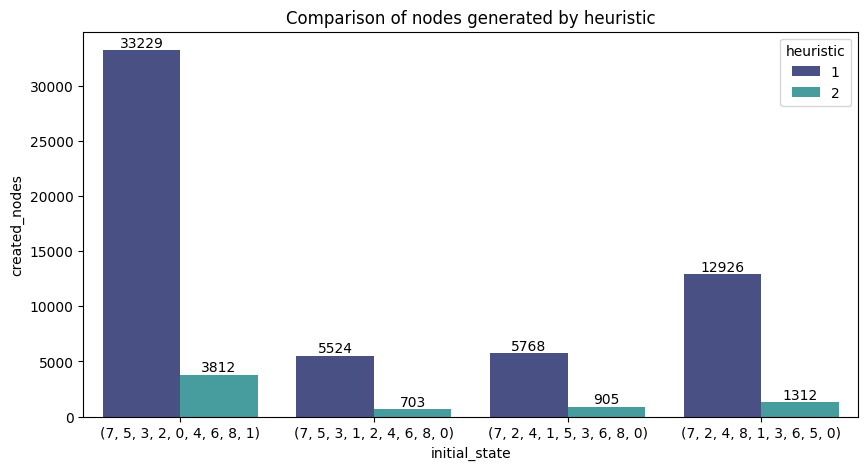

In [11]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='initial_state', y='created_nodes',
                hue='heuristic', data=result,
                errwidth=0,
                palette="mako")
 
ax.set_title('Comparison of nodes generated by heuristic')

for i in ax.containers:
    ax.bar_label(i,)

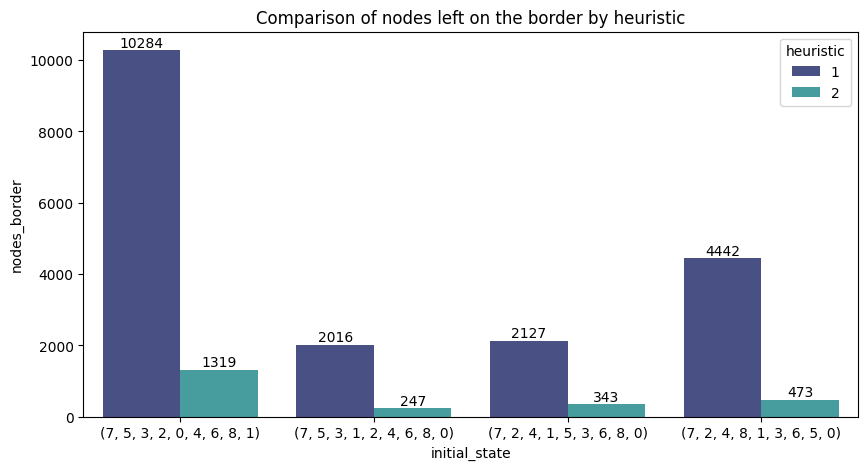

In [12]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='initial_state', y='nodes_border',
                 hue='heuristic', data=result,
                 errwidth=0,
                 palette="mako")
 
ax.set_title('Comparison of nodes left on the border by heuristic')

for i in ax.containers:
    ax.bar_label(i,)

As we can see, the choice of heuristic in the A* algorithm is crucial because it directly influences the efficiency, accuracy and overall performance of the algorithm. A good heuristic guides the search effectively towards the optimal solution, reducing computational requirements and making A* a powerful tool for solving complex pathfinding and graph traversal problems.